# 📊 MongoDB Document Structure Analysis

This notebook explores the structural properties of the MongoDB-stored OpenFDA Adverse Event reports. It is part of the BEP project comparing a semi-structured NoSQL design (MongoDB) with a normalized relational schema (SQLite).

In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import numpy as np
import pprint

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')  # Adjust if needed
db = client["openfda_converted"]
collection = db['full_reports']
print(f"Connected to collection with {collection.count_documents({})} documents")

Connected to collection with 35999 documents


In [2]:
# Inspect top-level keys and frequencies across a sample
sample = list(collection.find({}, {'_id': 0}).limit(1000))
key_counts = Counter()
for doc in sample:
    key_counts.update(doc.keys())
pd.DataFrame(key_counts.items(), columns=['Key', 'Frequency']).sort_values(by='Frequency', ascending=False)

,Key,Frequency
0,safetyreportversion,1000
17,receiptdate,1000
15,receivedate,1000
14,receivedateformat,1000
1,safetyreportid,1000
18,fulfillexpeditecriteria,1000
20,primarysource,1000
21,sender,1000
22,receiver,1000
7,serious,1000


In [3]:
# Example inspection of nested fields
pprint.pprint(sample[0].get('patient', {}))
pprint.pprint(sample[0].get('patient', {}).get('drug', []))

{'drug': [{'actiondrug': 5,
           'activesubstance': {'activesubstancename': 'DUVELISIB'},
           'drugadditional': 3,
           'drugadministrationroute': 48,
           'drugauthorizationnumb': 211155,
           'drugbatchnumb': '1697765A',
           'drugcharacterization': 1,
           'drugdosageform': 'Capsule',
           'drugdosagetext': '75 MG, BID',
           'drugindication': 'Non-Hodgkin^s lymphoma',
           'drugintervaldosagedefinition': 804,
           'drugintervaldosageunitnumb': 1.0,
           'drugrecurreadministration': 3,
           'drugseparatedosagenumb': 2.0,
           'drugstructuredosagenumb': 75.0,
           'drugstructuredosageunit': 3,
           'medicinalproduct': 'COPIKTRA',
           'openfda': {'application_number': ['NDA211155'],
                       'brand_name': ['COPIKTRA'],
                       'generic_name': ['DUVELISIB'],
                       'manufacturer_name': ['Secura Bio, Inc'],
                       'package_n

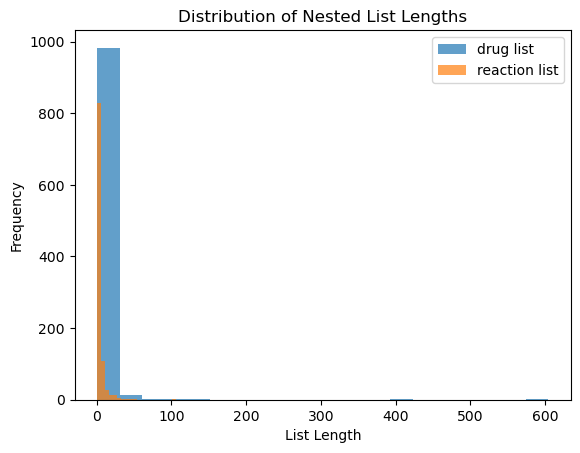

In [4]:
# Length distribution of patient.drug, patient.reaction, etc.
drug_lengths = [len(doc.get('patient', {}).get('drug', [])) for doc in sample]
reaction_lengths = [len(doc.get('patient', {}).get('reaction', [])) for doc in sample]

plt.hist(drug_lengths, bins=20, alpha=0.7, label='drug list')
plt.hist(reaction_lengths, bins=20, alpha=0.7, label='reaction list')
plt.xlabel('List Length')
plt.ylabel('Frequency')
plt.title('Distribution of Nested List Lengths')
plt.legend()
plt.show()

In [5]:
# openfda key count diversity across drugs
openfda_key_counts = Counter()
for doc in sample:
    for drug in doc.get('patient', {}).get('drug', []):
        openfda = drug.get('openfda', {})
        openfda_key_counts[len(openfda.keys())] += 1
pd.DataFrame(openfda_key_counts.items(), columns=['Number of Keys in openfda', 'Count'])

,Number of Keys in openfda,Count
0,13,1840
1,17,786
2,16,2254
3,14,47
4,12,45
5,0,1111
6,10,84
7,18,112
8,11,29
9,15,701


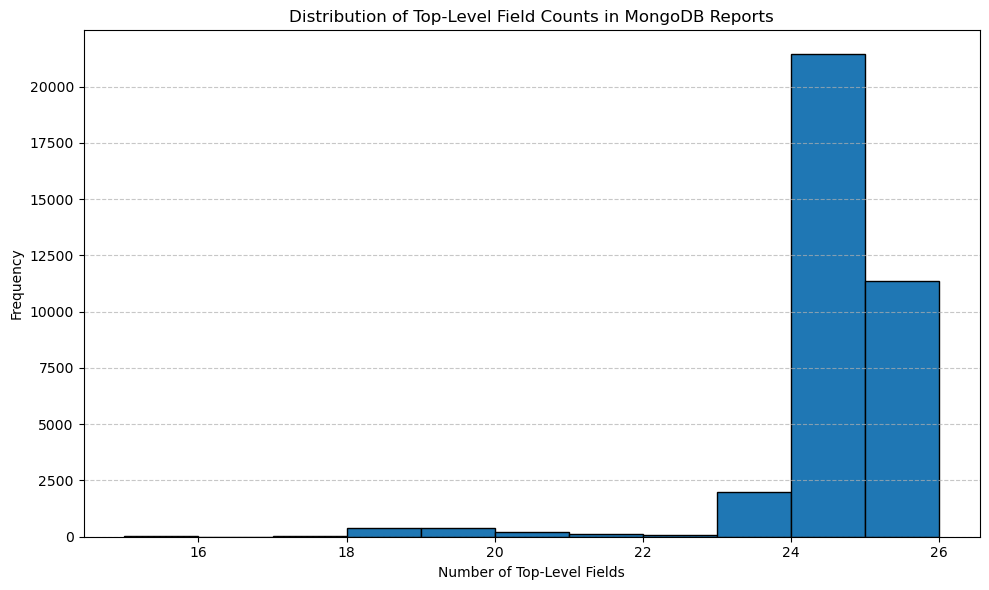

In [6]:
# Compute top-level field counts for all documents
cursor = collection.find({}, {'_id': 0})
field_counts = [len(doc.keys()) for doc in cursor]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(field_counts, bins=range(min(field_counts), max(field_counts) + 1), edgecolor='black')
plt.title("Distribution of Top-Level Field Counts in MongoDB Reports")
plt.xlabel("Number of Top-Level Fields")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

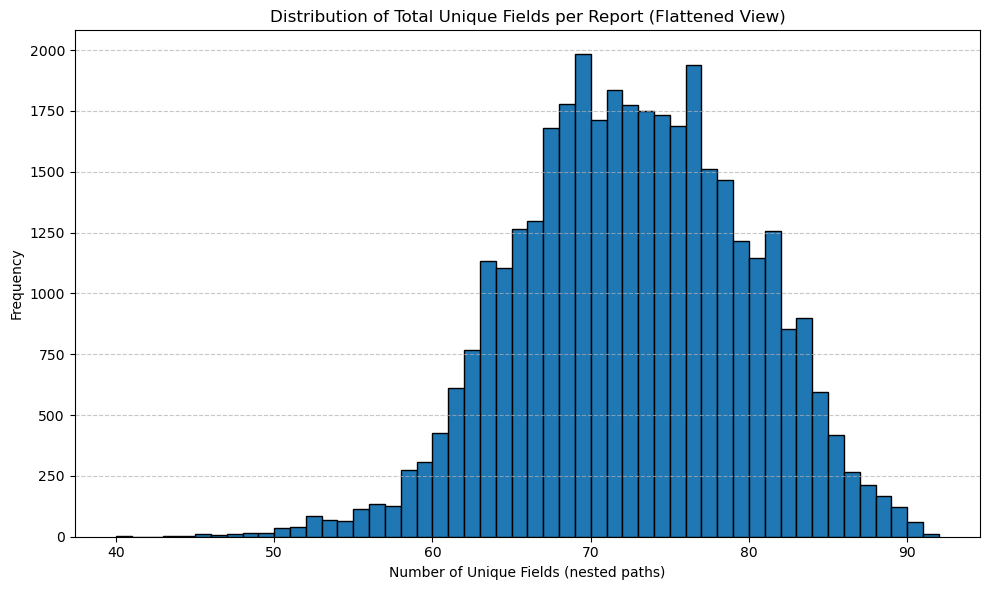

In [ ]:
def get_all_keys(d, prefix=''):
    """Recursively extract unique field paths from nested dictionaries/lists."""
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            full_key = f"{prefix}.{k}" if prefix else k
            keys.add(full_key)
            keys.update(get_all_keys(v, prefix=full_key))
    elif isinstance(d, list):
        for item in d:
            keys.update(get_all_keys(item, prefix=prefix))
    return keys

# Sample reports from the collection
cursor = collection.find({}, {'_id': 0})
unique_key_counts = [len(get_all_keys(doc)) for doc in cursor]




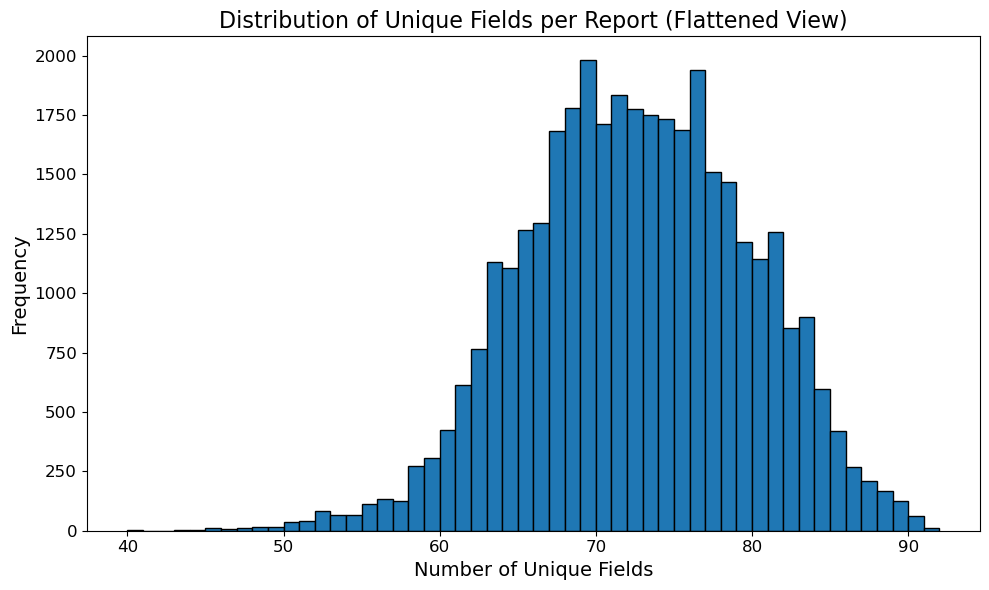

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(unique_key_counts, bins=range(min(unique_key_counts), max(unique_key_counts) + 1), edgecolor='black')
plt.title("Distribution of Unique Fields per Report (Flattened View)", fontsize=16)
plt.xlabel("Number of Unique Fields", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()